In [1]:
import numpyro
numpyro.set_platform('cpu')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import jax.numpy as jnp

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
def plot_performance(axes, results, num_epochs, ylims=[[.7, .95]]):
    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)

    for i, ylim in enumerate(ylims):
        axes[i].set_ylim(ylim)

def plot_compression(results, num_epochs, ax, labels=['mlp', 'lenet', 'vit', 'mixer']):
    names = ['MLP', 'LeNet', 'ViT', 'Mixer']
    for i, label in enumerate(labels):
        try:
            for key in results[label]:
                vals = results[label][key]
                try:
                    ax.plot(range(1, num_epochs + 1), vals['zip'], 'o:', label=names[i])
                except:
                    pass
        except:
            pass


    ax.set_xlabel('epoch')
    ax.set_ylim([.2, 1])

In [4]:
# load results
fm_results = jnp.load('../results/fashion_mnist.npz', allow_pickle=True)['results'].item()

c10_results = jnp.load('../results/cifar10.npz', allow_pickle=True)['results'].item()

c100_results = jnp.load('../results/cifar100.npz', allow_pickle=True)['results'].item()

num_epochs = 5

# Fashion MNIST

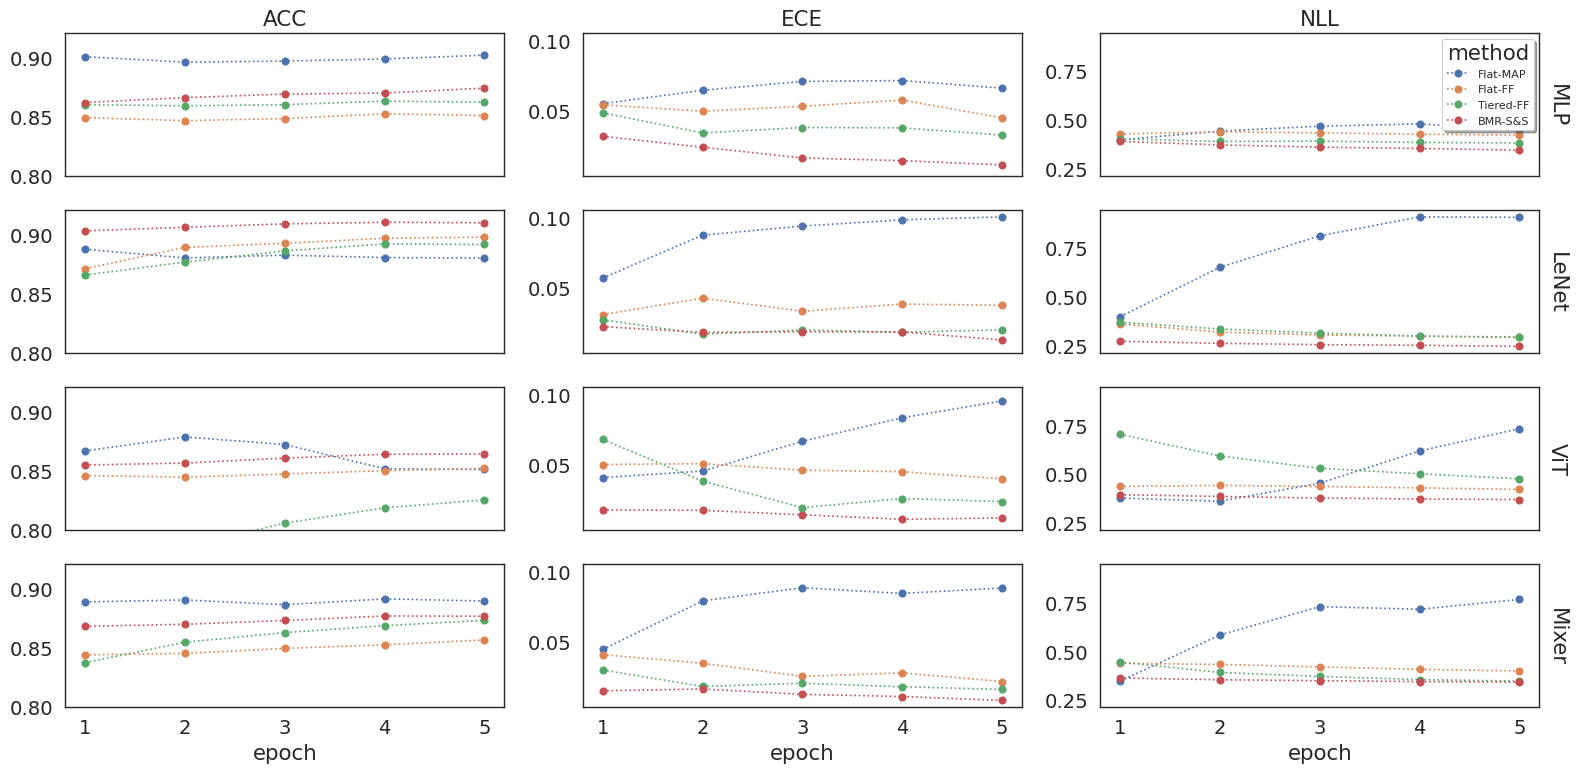

In [5]:
fig, axes = plt.subplots(4, 3, figsize=(16, 8), sharex=True, sharey='col')

plot_performance(axes[0], fm_results['mlp'], num_epochs);
plot_performance(axes[1], fm_results['lenet'], num_epochs);
plot_performance(axes[2], fm_results['vit'], num_epochs);
plot_performance(axes[3], fm_results['mixer'], num_epochs, ylims=[[.8, .92]]);


axes[0, -1].legend(loc=1, fancybox=True, shadow=True, title='method', fontsize=8)

for i, label in enumerate(['ACC', 'ECE', 'NLL']):
    axes[0, i].set_title(label)
    axes[-1, i].set_xlabel('epoch')

for i, label in enumerate(['MLP', 'LeNet', 'ViT', 'Mixer']):
    axes[i, -1].text(1.04, 0.5, label, horizontalalignment='center',
    verticalalignment='center', rotation=-90, transform=axes[i, -1].transAxes)

fig.tight_layout()
fig.savefig('Fig1.pdf', bbox_inches='tight', transparent=True, dpi=300)

## Cifar10

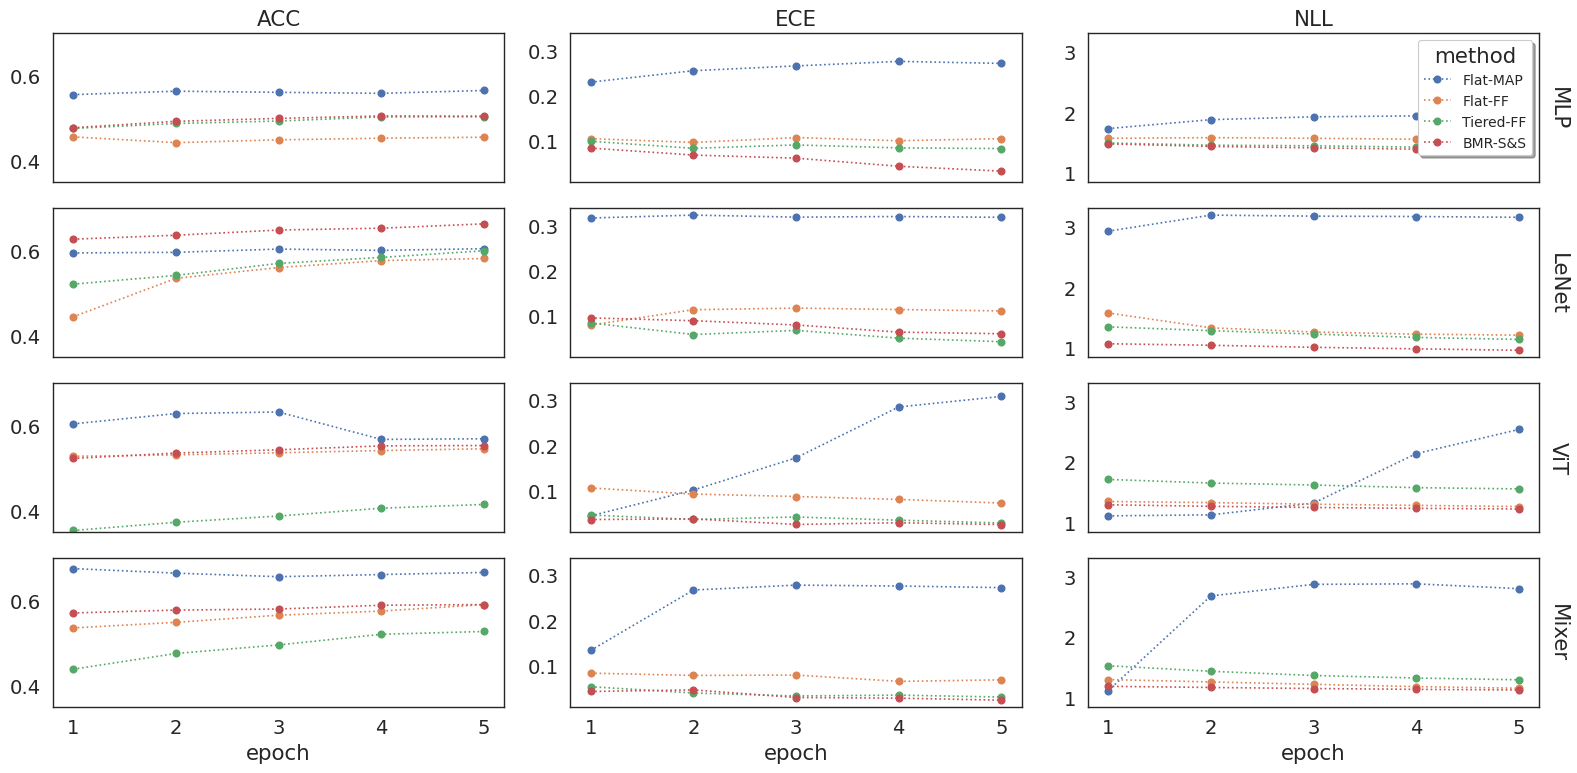

In [44]:
fig, axes = plt.subplots(4, 3, figsize=(16, 8), sharex=True, sharey='col')

plot_performance(axes[0], c10_results['mlp'], num_epochs);
plot_performance(axes[1], c10_results['lenet'], num_epochs);
plot_performance(axes[2], c10_results['vit'], num_epochs);
plot_performance(axes[3], c10_results['mixer'], num_epochs, ylims=[[.35, .7]]);


axes[0, -1].legend(loc=0, fancybox=True, shadow=True, title='method', fontsize=10)

for i, label in enumerate(['ACC', 'ECE', 'NLL']):
    axes[0, i].set_title(label)
    axes[-1, i].set_xlabel('epoch')

for i, label in enumerate(['MLP', 'LeNet', 'ViT', 'Mixer']):
    axes[i, -1].text(1.04, 0.5, label, horizontalalignment='center',
    verticalalignment='center', rotation=-90, transform=axes[i, -1].transAxes)
    
fig.tight_layout()
fig.savefig('Fig1-Sup1.pdf', bbox_inches='tight', transparent=True, dpi=300)

# CIFAR 100

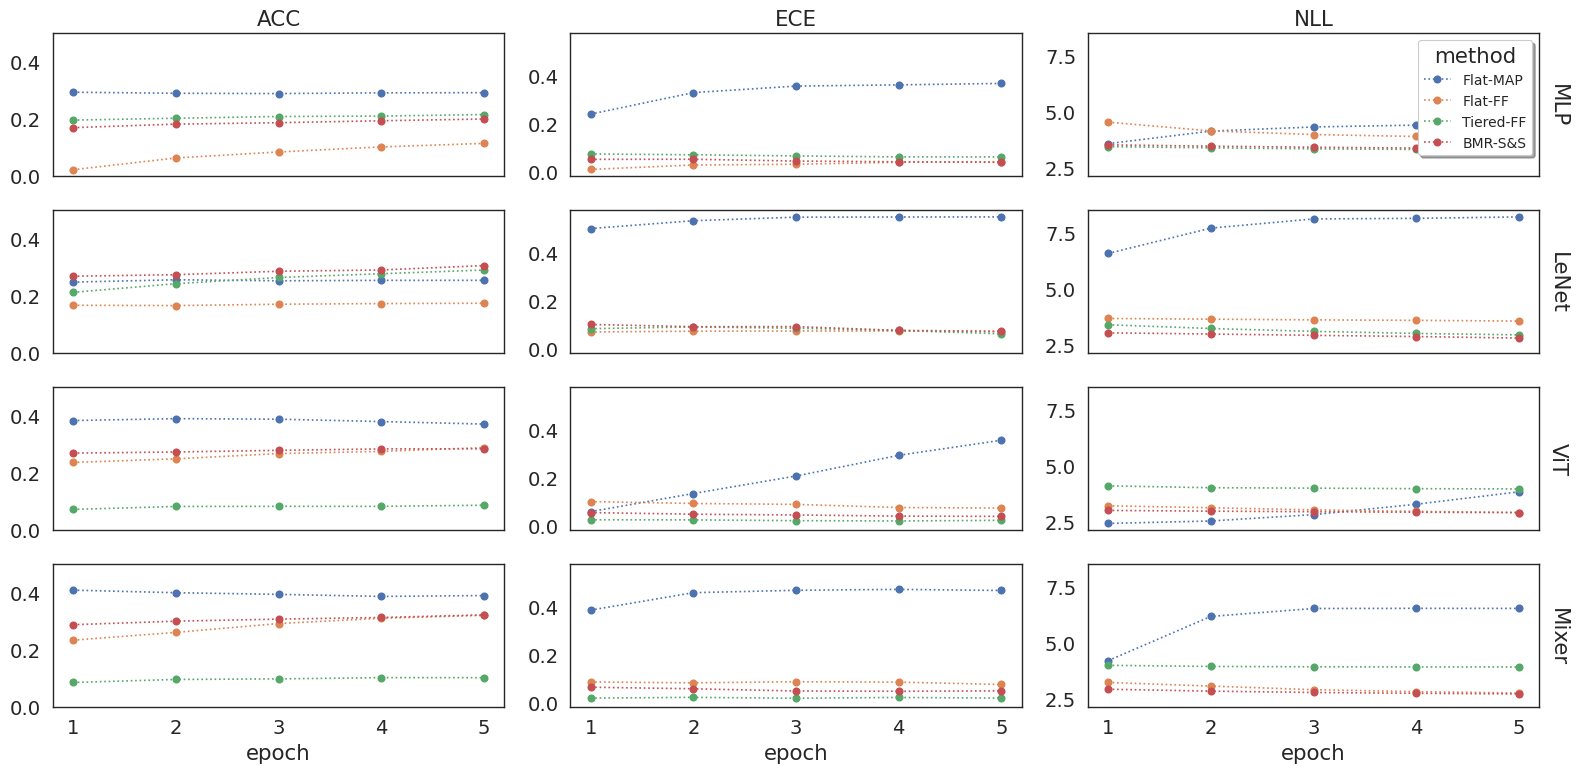

In [45]:
fig, axes = plt.subplots(4, 3, figsize=(16, 8), sharex=True, sharey='col')

plot_performance(axes[0], c100_results['mlp'], num_epochs);
plot_performance(axes[1], c100_results['lenet'], num_epochs);
plot_performance(axes[2], c100_results['vit'], num_epochs);
plot_performance(axes[3], c100_results['mixer'], num_epochs, ylims=[[.0, .5]]);

axes[0, -1].legend(loc=0, fancybox=True, shadow=True, title='method', fontsize=10)

for i, label in enumerate(['ACC', 'ECE', 'NLL']):
    axes[0, i].set_title(label)
    axes[-1, i].set_xlabel('epoch')

for i, label in enumerate(['MLP', 'LeNet', 'ViT', 'Mixer']):
    axes[i, -1].text(1.04, 0.5, label, horizontalalignment='center',
    verticalalignment='center', rotation=-90, transform=axes[i, -1].transAxes)
    
fig.tight_layout()
fig.savefig('Fig1-Sup2.pdf', bbox_inches='tight', transparent=True, dpi=300)

# Compression

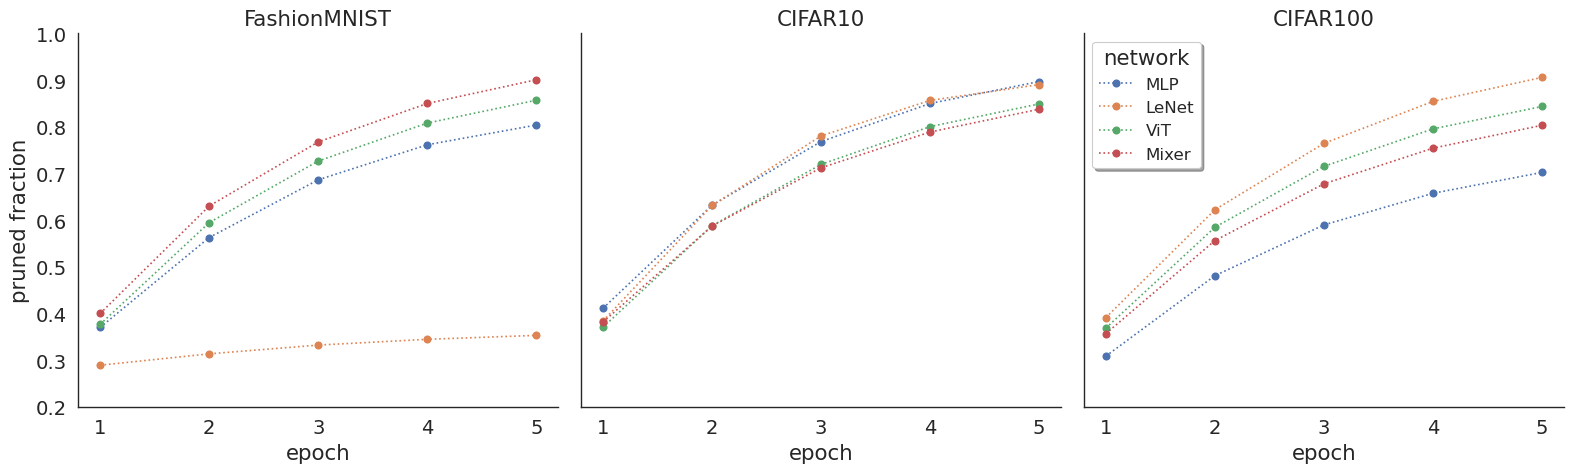

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

datasets = [fm_results, c10_results, c100_results]
for i, ax in enumerate(axes):
    plot_compression(datasets[i], num_epochs, axes[i]);

axes[0].set_ylabel('pruned fraction')
axes[0].set_title('FashionMNIST')
axes[1].set_title('CIFAR10')
axes[2].set_title('CIFAR100')

axes[-1].legend(loc=0, fancybox=True, shadow=True, title='network', fontsize=12)

fig.tight_layout()
sns.despine(fig)
fig.savefig('Fig2.pdf', bbox_inches='tight', transparent=True, dpi=300)

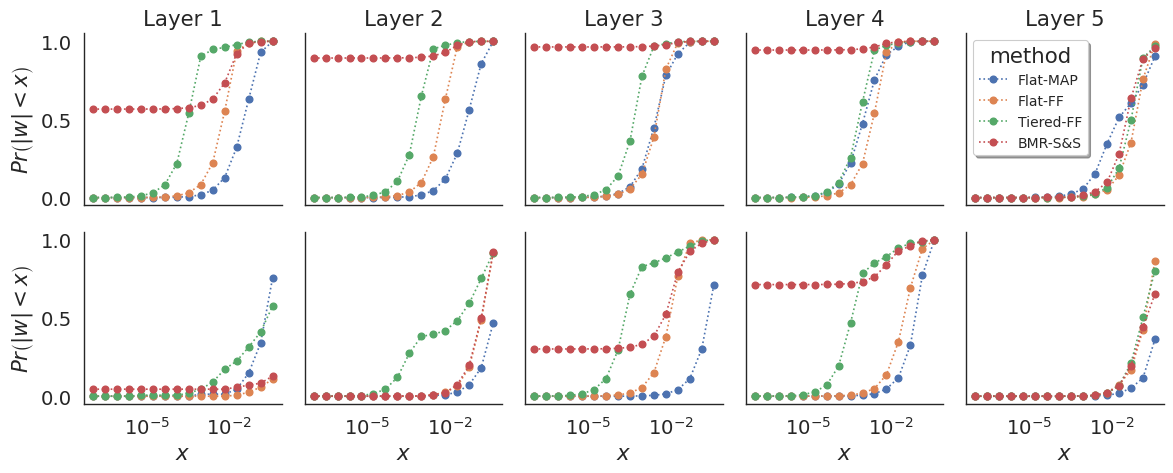

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5), sharex=True, sharey=True)

### cumulative distribution function over layers ###
xs = jnp.exp(jnp.arange(16) - 16)
for i, nn_type in enumerate(['mlp', 'lenet']):
    for _, key in enumerate(fm_results[nn_type]):
        for l in range(5):
            w = jnp.abs(jnp.ravel(fm_results[nn_type][key]['samples'][f'layer{l}.weight'].mean(0)))
        
            hazard = []
            for x in xs:
                hazard.append( (w < x).mean() )

            axes[i, l].semilogx(xs, hazard, 'o:', label=key)

for l in range(5):
    axes[0, l].set_title(f'Layer {l + 1}')
    axes[-1, l].set_xlabel(r'$x$')

for i in range(2):
    axes[i, 0].set_ylabel(r'$Pr\left(|w| < x\right)$')

axes[0, -1].legend(loc=0, fancybox=True, shadow=True, title='method', fontsize=10)

sns.despine(fig)
fig.tight_layout()
fig.savefig('Fig3.pdf', bbox_inches='tight', transparent=True, dpi=300)

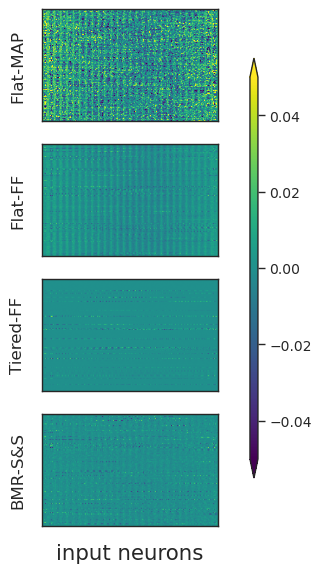

In [41]:
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex='col', sharey='row')

### mlp ###
for i, key in enumerate(['Flat-MAP', 'Flat-FF', 'Tiered-FF', 'BMR-S&S']):
    for l in range(1):
        # sns.heatmap(fm_results['mlp'][key]['samples'][f'layer{l}.weight'].mean(0), cmap='viridis', ax=axes[i], vmax=.05, vmin=-.05, cbar=False)
        im = axes[i].imshow(fm_results['mlp'][key]['samples'][f'layer{l}.weight'].mean(0), cmap='viridis', vmax=.05, vmin=-.05)
    
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('output neurons')
    axes[i].set_ylabel(key, fontsize=12)


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([.65, 0.18, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='both')
tick_font_size = 10
cbar.ax.tick_params(labelsize=tick_font_size)

axes[-1].set_xticklabels([])
axes[-1].set_xlabel('input neurons')

fig.tight_layout()
fig.savefig('Fig4-1.pdf', bbox_inches='tight', transparent=True, dpi=300)

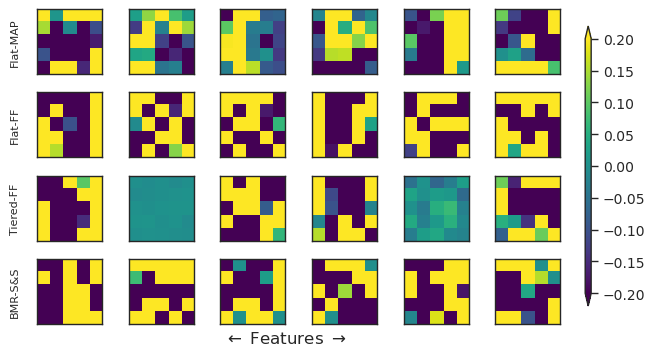

In [42]:
fig, axes = plt.subplots(4, 6, figsize=(6, 4), sharex=True, sharey=True)

for k, name in enumerate(['Flat-MAP', 'Flat-FF', 'Tiered-FF', 'BMR-S&S']):
    w = fm_results['lenet'][name]['samples']['layer0.weight'].mean(0)[:, :-1].reshape(6, 5, 5)

    for i in range(6):
        for j in range(3):
            im = axes[k, i].imshow( w[i], cmap='viridis', vmax=.2, vmin=-.2)
            axes[k, i].set_xticklabels([])
            axes[k, i].set_yticklabels([])

    axes[k, 0].set_ylabel(name, fontsize=8)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.0, 0.2, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='both')
tick_font_size = 10
cbar.ax.tick_params(labelsize=tick_font_size)

fig.supxlabel(r'$\leftarrow$ Features $\rightarrow$', y=0.1, fontsize=12)

fig.tight_layout()
fig.savefig('Fig4-2.pdf', bbox_inches='tight', transparent=True, dpi=300)

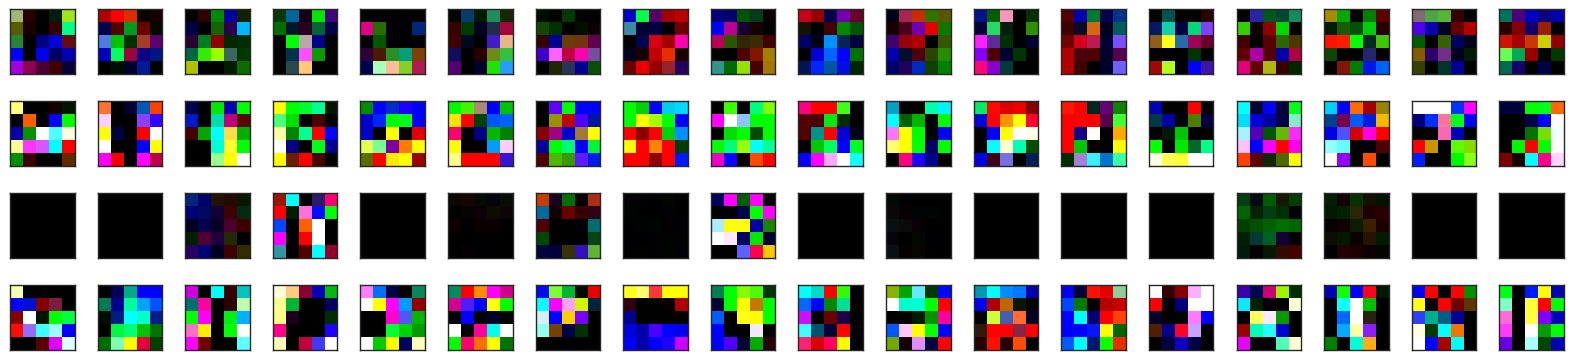

In [ ]:
fig, axes = plt.subplots(4, 18, figsize=(16, 4), sharex=True, sharey=True)

for k, name in enumerate(['Flat-MAP', 'Flat-FF', 'Tiered-FF', 'BMR-S&S']):
    w = c10_results['lenet'][name]['samples']['layer0.weight'].mean(0)[:, :-1].reshape(18, 3, 5, 5)

    for i in range(18):
        for j in range(3):
            axes[k, i].imshow( jnp.clip(w[i], a_min=0., a_max=1.).transpose(1, 2, 0))
            axes[k, i].set_xticklabels([])
            axes[k, i].set_yticklabels([])

fig.tight_layout()

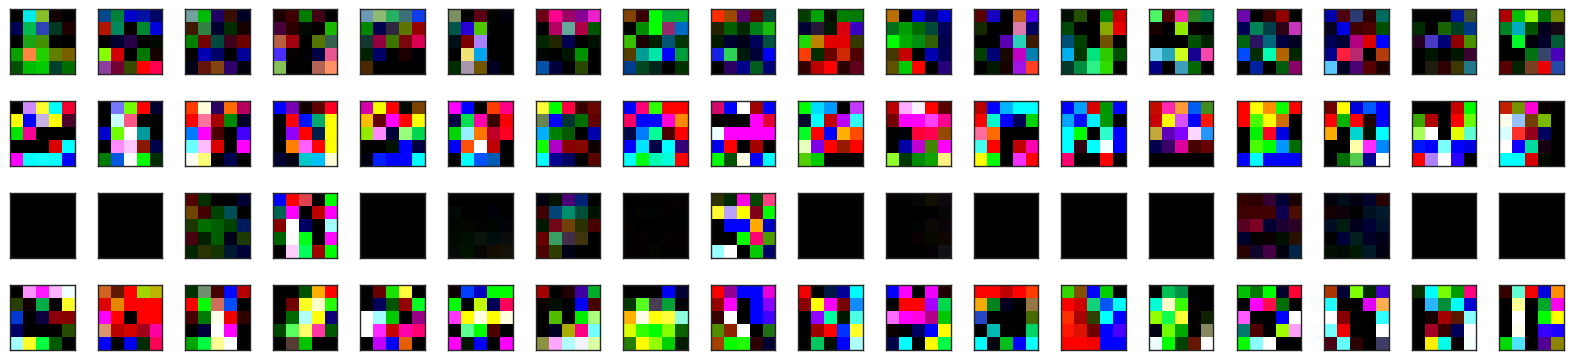

In [ ]:
fig, axes = plt.subplots(4, 18, figsize=(16, 4), sharex=True, sharey=True)

for k, name in enumerate(['Flat-MAP', 'Flat-FF', 'Tiered-FF', 'BMR-S&S']):
    w = c10_results['lenet'][name]['samples']['layer0.weight'].mean(0)[:, :-1].reshape(18, 3, 5, 5)

    for i in range(18):
        for j in range(3):
            axes[k, i].imshow( -jnp.clip(w[i], a_min=-1., a_max=0.).transpose(1, 2, 0))
            axes[k, i].set_xticklabels([])
            axes[k, i].set_yticklabels([])

fig.tight_layout()